Raw matches preview:
    match_id   season    stage       date            home_team            away_team  home_goals  away_goals
0         4  2021/22  Quarter 2021-04-06             AC Milan          Real Madrid           0           2
1         5  2021/22  Quarter 2021-04-13  Paris Saint-Germain    FC Bayern München           2           2
2         6  2021/22     Semi 2021-04-27           Chelsea FC      Manchester City           1           0
3         1  2021/22    Group 2021-09-14          Real Madrid  Paris Saint-Germain           2           1
4         2  2021/22    Group 2021-09-15      Manchester City           Chelsea FC           3           1
5         3  2021/22    Group 2021-09-21    FC Bayern München         Liverpool FC           1           3

Long per-team-per-match (first 10 rows):
    match_id   season    stage       date                 team             opp_team  gf  ga
0         2  2021/22    Group 2021-09-15           Chelsea FC      Manchester City   1   3
1   

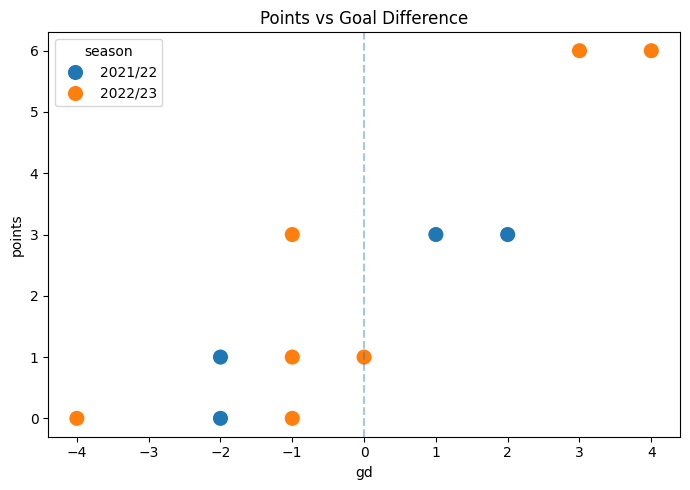

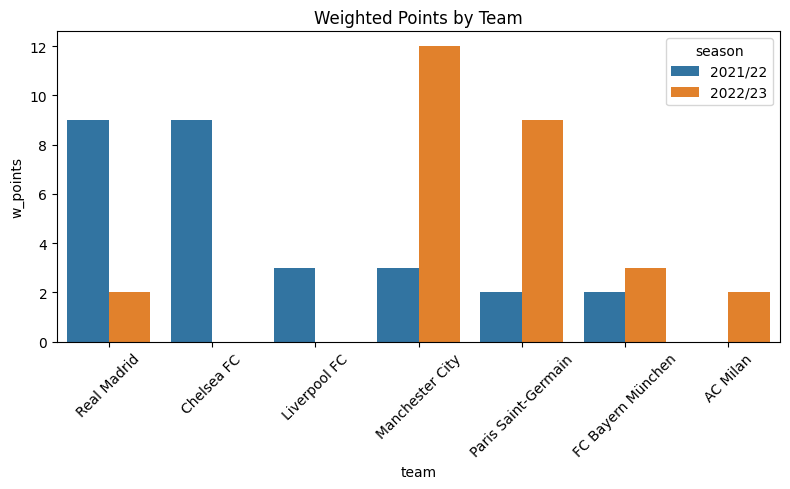

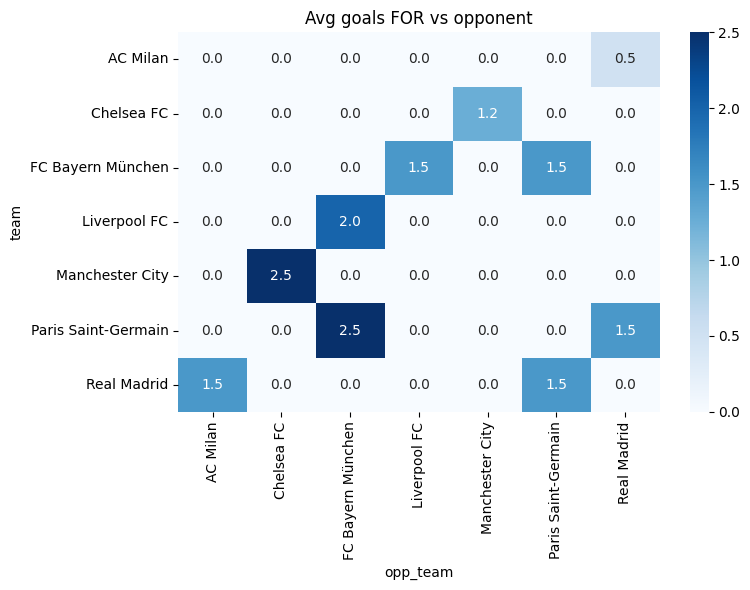


Saved figures: fig_points_vs_gd.png, fig_weighted_points.png, fig_opponent_heatmap.png


In [15]:
# === CHAMPIONS LEAGUE — FULL RECAP PIPELINE (with explanations) ===
# Skills: tidy home/away -> long, standings, ranking, rolling form, weighted points, visuals

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_rows", 120)

# ------------------------------------------------------------
# 0) Tiny synthetic dataset: 2 seasons × 3 stages × 6 teams
#    (You can swap this later for a Kaggle CSV.)
# ------------------------------------------------------------
matches = pd.DataFrame({
    "match_id": np.arange(1, 13),
    "season":    ["2021/22"]*6 + ["2022/23"]*6,
    "stage":     ["Group","Group","Group","Quarter","Quarter","Semi"]*2,
    "date": [
        "2021-09-14","2021-09-15","2021-09-21",
        "2021-04-06","2021-04-13","2021-04-27",
        "2022-09-14","2022-09-15","2022-09-21",
        "2022-04-06","2022-04-13","2022-04-27"
    ],
    # Use real-ish team names that also match many public datasets
    "home_team": [
        "Real Madrid", "Manchester City", "FC Bayern München",
        "AC Milan", "Paris Saint-Germain", "Chelsea FC",
        "Real Madrid", "Manchester City", "FC Bayern München",
        "AC Milan", "Paris Saint-Germain", "Chelsea FC"
    ],
    "away_team": [
        "Paris Saint-Germain","Chelsea FC","Liverpool FC",
        "Real Madrid","FC Bayern München","Manchester City",
        "Paris Saint-Germain","Chelsea FC","Liverpool FC",
        "Real Madrid","FC Bayern München","Manchester City"
    ],
    "home_goals":[2,3,1,0,2,1, 1,4,2,1,3,2],
    "away_goals":[1,1,3,2,2,0, 2,1,1,1,1,3]
})

# Dates -> datetime, sorted by date (good hygiene)
matches["date"] = pd.to_datetime(matches["date"], errors="coerce")
matches = matches.sort_values("date").reset_index(drop=True)
print("Raw matches preview:\n", matches.head(6))

# ------------------------------------------------------------
# 1) Tidy LONG table per-team-per-match
#    We create a "home view" and an "away view", then stack them.
#    gf = goals for, ga = goals against, opp_team = opponent
# ------------------------------------------------------------
home = (matches[["match_id","season","stage","date","home_team","away_team","home_goals","away_goals"]]
        .rename(columns={"home_team":"team","away_team":"opp_team",
                         "home_goals":"gf","away_goals":"ga"}))

away = (matches[["match_id","season","stage","date","away_team","home_team","away_goals","home_goals"]]
        .rename(columns={"away_team":"team","home_team":"opp_team",
                         "away_goals":"gf","home_goals":"ga"}))

# pd.concat(..., ignore_index=True) vertically stacks DataFrames and rebuilds a clean index.
long = (pd.concat([home,away], ignore_index=True)
        .sort_values(["season","stage","team","date"])
        .reset_index(drop=True))

print("\nLong per-team-per-match (first 10 rows):\n", long.head(10))

# ------------------------------------------------------------
# 2) Result + points per row (vectorized IF/ELSE with np.select)
# ------------------------------------------------------------

long["result"] = np.select(
    [long["gf"] > long["ga"], long["gf"] < long["ga"]],
    ["Win","Loss"], default="Draw"
)

# Win=3, Draw=1, Loss=0
long["points"] = np.select(
    [long["result"].eq("Win") , long["result"].eq("Draw")],
    [3,1], default=0
)

print("\nResults/points preview:\n", long[["season","stage","team","opp_team","gf","ga","result","points"]].head(8))

# ------------------------------------------------------------
# 3) Standings table per (season, team)
#    .agg with named tuples: ("new_col", "how")
# ------------------------------------------------------------

standings = (long
             .groupby(["season","team"],as_index=False)
             .agg(
                 matches=("match_id","count"),
                 wins=("result", lambda s: (s=="Win").sum()),
                 draws  =("result", lambda s: (s=="Draw").sum()),
                 losses =("result", lambda s: (s=="Loss").sum()),
                 gf     =("gf","sum"),
                 ga     =("ga","sum"),
                 points =("points","sum")
             ))
standings["gd"] = standings["gf"] - standings["ga"]   # goal difference
print("\nStandings (pre-rank):\n", standings)

# ------------------------------------------------------------
# 4) Ranking with tiebreakers:
#    Sort by points ↓, then GD ↓, then GF ↓ *inside each season*.
#    groupby(...).cumcount()+1 gives a 1-based rank after sorting.
# ------------------------------------------------------------

standings_ranked = (standings
                    .sort_values(["season","points","gd","gf"], ascending=[True,False,False,False])
                    .assign(rank = lambda d: d.groupby("season").cumcount()+1))
print("\nStandings with rank:\n", standings_ranked)

# Top-2 per season
top2 = (standings_ranked
        .sort_values(["season","rank"])
        .groupby("season", group_keys=False)
        .head(2))
print("\nTop-2 per season:\n", top2)

# ------------------------------------------------------------
# 5) Rolling form: last 3 matches per team
#    Idea: convert result->pts; within each team, use rolling(3).sum()
# ------------------------------------------------------------
# Sort by team then date to simulate "time"
long_timed = long.sort_values(["team","date"]).reset_index(drop=True)

long_timed["form3"] = (long_timed
                       .groupby("team",group_keys=False)["points"]
                       .rolling(window=3,min_periods=1)
                       .sum()
                       .reset_index(level=0,drop=True))
print("\nRolling form (3-match points) preview:\n",
      long_timed[["team","date","points","form3"]].head(15))

# ------------------------------------------------------------
# 6) Weighted points by stage (toy meta)
#    We join round weights and recompute a "weighted points" table.
# ------------------------------------------------------------
stages_meta = pd.DataFrame({
    "stage": ["Group","Quarter","Semi","Final"],
    "stage_weight": [1, 2, 3, 4]   # You can tune these later
})

long_w = long.merge(stages_meta, on="stage", how="left").fillna({"stage_weight":1})
long_w["weighted_points"] = long_w["points"] * long_w["stage_weight"]

weighted_table = (long_w
    .groupby(["season","team"], as_index=False)
    .agg(
        matches=("match_id","count"),
        points=("points","sum"),
        w_points=("weighted_points","sum"),
        gf=("gf","sum"), ga=("ga","sum")
    )
    .assign(gd=lambda d: d["gf"] - d["ga"])
    .sort_values(["season","w_points","gd","gf"], ascending=[True,False,False,False])
)
print("\nWeighted standings:\n", weighted_table)

# ------------------------------------------------------------
# 7) Opponent matrix: average goals-for vs opponent (pivot)
#    Then plot as a heatmap to spot strong/weak matchups.
# ------------------------------------------------------------
matrix_for = pd.pivot_table(
    long, values="gf", index="team", columns="opp_team",
    aggfunc="mean", fill_value=0
)
print("\nAvg goals FOR vs opponent (matrix):\n", matrix_for.round(2))

# ------------------------------------------------------------
# 8) Visuals (save 3 figures) — story-ready
# ------------------------------------------------------------
# FIG 1 — Points vs GD scatter
plt.figure(figsize=(7,5))
sns.scatterplot(data=standings_ranked,x="gd", y="points", hue="season", s=140)
plt.axvline(0, ls="--", alpha=0.4)
plt.title("Points vs Goal Difference")
plt.tight_layout()
plt.savefig("fig_points_vs_gd.png", dpi=160)
plt.show()

# FIG 2 — Weighted points bar
plt.figure(figsize=(8,5))
sns.barplot(data=weighted_table,x="team", y="w_points", hue="season")
plt.xticks(rotation=45)
plt.title("Weighted Points by Team")
plt.tight_layout()
plt.savefig("fig_weighted_points.png", dpi=160)
plt.show()

# FIG 3 — Opponent heatmap
plt.figure(figsize=(8,6))
sns.heatmap(matrix_for, annot=True, fmt=".1f", cmap="Blues")
plt.title("Avg goals FOR vs opponent")
plt.tight_layout()
plt.savefig("fig_opponent_heatmap.png", dpi=160)
plt.show()

print("\nSaved figures: fig_points_vs_gd.png, fig_weighted_points.png, fig_opponent_heatmap.png")



